In [13]:
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt

In [2]:
clean_data = pd.read_csv('/Users/marywu/Desktop/Desktop - mary/open your eyes./Northwestern/357/US_Elections_2024/cleaned_data.csv')

# Take the most recent poll for each state
clean_data['end_date'] = pd.to_datetime(clean_data['end_date'])
latest_polls = clean_data.sort_values(by='end_date').groupby('state').tail(1)
latest_polls_sorted = latest_polls.sort_index().reset_index(drop=True).rename(lambda x: x + 1, axis=0)
latest_polls_sorted

,state,pollster,start_date,end_date,sample_size,Trump,Harris,Other
1,Alaska,Alaska Survey Research,2024-10-20,2024-10-22,1703.0,53.00,44.00,3.00
2,Arizona,AtlasIntel,2024-10-25,2024-10-29,1458.0,50.70,46.85,2.45
3,Arkansas,Hendrix College,2024-09-05,2024-09-06,696.0,55.00,40.00,5.00
4,California,ActiVote,2024-10-07,2024-10-27,400.0,37.20,62.80,0.00
5,Colorado,ActiVote,2024-09-15,2024-10-19,400.0,41.30,58.70,0.00
6,Connecticut,MassINC Polling Group,2024-09-12,2024-09-18,800.0,37.00,53.00,10.00
7,Delaware,Slingshot Strategies,2024-09-19,2024-09-21,500.0,37.00,54.00,9.00
8,Florida,Florida Atlantic University/Mainstreet Research,2024-10-19,2024-10-27,897.0,53.00,44.00,3.00
9,Georgia,AtlasIntel,2024-10-25,2024-10-29,1429.0,50.55,47.30,2.15
10,Illinois,ActiVote,2024-10-04,2024-10-28,400.0,41.60,58.40,0.00


In [3]:
electoral_vote_counts = {
    'Alabama': 9, 'Alaska': 3, 'Arizona': 11, 'Arkansas': 6, 'California': 54,
    'Colorado': 10, 'Connecticut': 7, 'Delaware': 3, 'District of Columbia': 3,
    'Florida': 30, 'Georgia': 16, 'Hawaii': 4, 'Idaho': 4, 'Illinois': 19,
    'Indiana': 11, 'Iowa': 6, 'Kansas': 6, 'Kentucky': 8, 'Louisiana': 8,
    'Maine': 2, 'Maine CD-1': 1, 'Maine CD-2': 1, 'Maryland': 10, 'Massachusetts': 11,
    'Michigan': 15, 'Minnesota': 10, 'Mississippi': 6, 'Missouri': 10,
    'Montana': 4, 'Nebraska': 2, 'Nebraska CD-1': 1, 'Nebraska CD-2': 1, 'Nebraska CD-3': 1,
    'Nevada': 6, 'New Hampshire': 4, 'New Jersey': 14, 'New Mexico': 5, 'New York': 28,
    'North Carolina': 16, 'North Dakota': 3, 'Ohio': 17, 'Oklahoma': 7, 'Oregon': 8,
    'Pennsylvania': 19, 'Rhode Island': 4, 'South Carolina': 9, 'South Dakota': 3,
    'Tennessee': 11, 'Texas': 40, 'Utah': 6, 'Vermont': 3, 'Virginia': 13,
    'Washington': 12, 'West Virginia': 4, 'Wisconsin': 10, 'Wyoming': 3
}

Let $y_1$, $y_2$, and $y_3$ be the number of votes for Harris, Trump, and others respectively. Then $y_1$, $y_2$, and $y_3$ are assumed to have a multinomial distribution with sample size $n$ and respective probabilities $\theta_1$, $\theta_2$, and $\theta_3$. Assuming a uniform (vague) prior Dirichlet(1, 1, 1), 
$$P(\theta\mid\text{data})\propto\theta_1^{y_1}\theta_2^{y_2}\theta_3^{y_3}$$
which is Dirichlet $(y_1+1, y_2+1, y_3+1)$. 

In [4]:
# Simulate the posterior Dirichlet distribution
sample_size = 500 # Following Jim Albert
win_probabilities = {}
np.random.seed(42)

for index, row in latest_polls.iterrows():
    state = row['state']
    harris_pct = row['Harris']
    trump_pct = row['Trump']
    other_pct = row['Other']
    
    dirichlet_params = [1 + harris_pct * sample_size / 100, 1 + trump_pct * sample_size / 100, 1 + other_pct * sample_size / 100]
    
    # Draw from Dirichlet distribution
    n_draws = 5000
    samples = np.random.dirichlet(dirichlet_params, n_draws) # Posterior probabilities
    
    # Proportion of draws where harris_pct > trump_pct
    harris_win = np.mean(samples[:, 0] > samples[:, 1])
    win_probabilities[state] = harris_win

In [5]:
# Add missing probabilities for states without polling data
missing_probabilities = {
    'Alabama': 0.00,
    'District of Columbia': 1.00,
    'Hawaii': 1.00,
    'Idaho': 0.00,
    'Kentucky': 0.00,
    'Louisiana': 0.00,
    'Mississippi': 0.00,
    'Wyoming': 0.00
}
win_probabilities.update(missing_probabilities)
win_probabilities = dict(sorted(win_probabilities.items()))
print(win_probabilities)

{'Alabama': 0.0, 'Alaska': 0.022, 'Arizona': 0.1894, 'Arkansas': 0.0002, 'California': 1.0, 'Colorado': 1.0, 'Connecticut': 0.9998, 'Delaware': 1.0, 'District of Columbia': 1.0, 'Florida': 0.0208, 'Georgia': 0.2412, 'Hawaii': 1.0, 'Idaho': 0.0, 'Illinois': 1.0, 'Indiana': 0.0002, 'Iowa': 0.061, 'Kansas': 0.006, 'Kentucky': 0.0, 'Louisiana': 0.0, 'Maine': 0.9478, 'Maine CD-1': 1.0, 'Maine CD-2': 0.0186, 'Maryland': 1.0, 'Massachusetts': 1.0, 'Michigan': 0.3872, 'Minnesota': 0.9666, 'Mississippi': 0.0, 'Missouri': 0.0002, 'Montana': 0.0, 'Nebraska': 0.0002, 'Nebraska CD-1': 0.0306, 'Nebraska CD-2': 0.9634, 'Nebraska CD-3': 0.0, 'Nevada': 0.4234, 'New Hampshire': 0.4626, 'New Jersey': 0.999, 'New Mexico': 0.9804, 'New York': 1.0, 'North Carolina': 0.5206, 'North Dakota': 0.0, 'Ohio': 0.0854, 'Oklahoma': 0.0, 'Oregon': 0.9982, 'Pennsylvania': 0.2846, 'Rhode Island': 0.9994, 'South Carolina': 0.0002, 'South Dakota': 0.0, 'Tennessee': 0.0, 'Texas': 0.0344, 'Utah': 0.0, 'Vermont': 1.0, 'Virgi

In [6]:
# Summary table
summary_table = pd.DataFrame({
    'State': sorted(win_probabilities.keys()), 
    'Harris %': [latest_polls_sorted.loc[latest_polls_sorted['state'] == state, 'Harris'].mean() for state in sorted(win_probabilities.keys())],
    'Trump %': [latest_polls_sorted.loc[latest_polls_sorted['state'] == state, 'Trump'].mean() for state in sorted(win_probabilities.keys())],
    'P(Harris wins)': [win_probabilities[state] for state in sorted(win_probabilities.keys())],
    'EV': [electoral_vote_counts[state] for state in sorted(win_probabilities.keys())]
})

summary_table['Harris %'] = summary_table['Harris %'].round(1)
summary_table['Trump %'] = summary_table['Trump %'].round(1)
summary_table['P(Harris wins)'] = summary_table['P(Harris wins)'].round(3)

summary_table.index += 1

# Display table
from IPython.display import display
display(summary_table)

,State,Harris %,Trump %,P(Harris wins),EV
1,Alabama,NaN,NaN,0.000,9
2,Alaska,44.0,53.0,0.022,3
3,Arizona,46.8,50.7,0.189,11
4,Arkansas,40.0,55.0,0.000,6
5,California,62.8,37.2,1.000,54
6,Colorado,58.7,41.3,1.000,10
7,Connecticut,53.0,37.0,1.000,7
8,Delaware,54.0,37.0,1.000,3
9,District of Columbia,NaN,NaN,1.000,3
10,Florida,44.0,53.0,0.021,30


In [7]:
np.random.seed(42)

# Simulate the election
n_simulations = 5000
harris_electoral_counts = np.zeros(n_simulations)

for i in range(n_simulations):
    harris_total = 0
    for state, prob_harris_wins in win_probabilities.items():
        # Simulate a biased coin flip
        if np.random.rand() < prob_harris_wins:
            harris_total += electoral_vote_counts.get(state, 0)
    harris_electoral_counts[i] = harris_total

harris_wins_count = np.sum(harris_electoral_counts >= 270)
trump_wins_count = n_simulations - harris_wins_count
harris_win_percentage = (harris_wins_count / n_simulations) * 100
trump_win_percentage = (trump_wins_count / n_simulations) * 100

Harris wins 28.72% of the time, and Trump wins 71.28% of the time.
Average EVs: Harris 259.54, Trump 278.46
Median EVs: Harris 258.00, Trump 280.00
Mode EVs: Harris 248.00, Trump 290.00


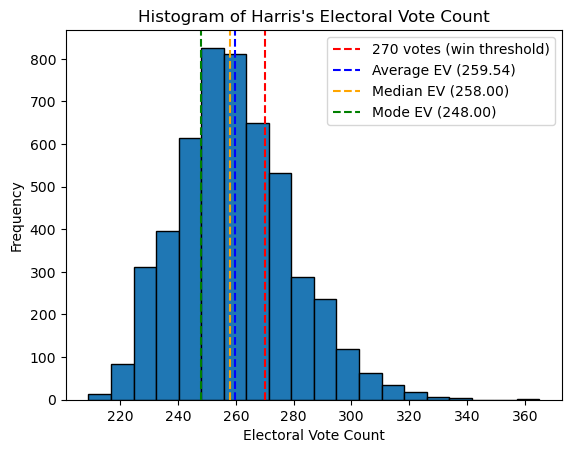

In [15]:
# Predict number of EVs
average_ev = np.mean(harris_electoral_counts)
median_ev = np.median(harris_electoral_counts)
mode_ev = stats.mode(harris_electoral_counts)[0]

print(f"Harris wins {harris_win_percentage:.2f}% of the time, and Trump wins {trump_win_percentage:.2f}% of the time.")
print(f"Average EVs: Harris {average_ev:.2f}, Trump {538 - average_ev:.2f}")
print(f"Median EVs: Harris {median_ev:.2f}, Trump {538 - median_ev:.2f}")
print(f"Mode EVs: Harris {mode_ev:.2f}, Trump {538 - mode_ev:.2f}")

# Plotting
plt.hist(harris_electoral_counts, bins=20, edgecolor='black')
plt.title("Histogram of Harris's Electoral Vote Count")
plt.xlabel("Electoral Vote Count")
plt.ylabel("Frequency")
plt.axvline(x=270, color='red', linestyle='--', label='270 votes (win threshold)')
plt.axvline(x=average_ev, color='blue', linestyle='--', label=f'Average EV ({average_ev:.2f})')
plt.axvline(x=median_ev, color='orange', linestyle='--', label=f'Median EV ({median_ev:.2f})')
plt.axvline(x=mode_ev, color='green', linestyle='--', label=f'Mode EV ({mode_ev:.2f})')
plt.legend()
plt.show()